# 2 - Workflow management with atomate

In this lesson we cover a few more advanced features of the atomate software package.  More specifically we'll go over an example that includes parents and children, talk more about where you can find preset workflows, and cover a basic example of analyzing workflow-generated materials data.

In [1]:
from mp_workshop.atomate import wf_to_graph, use_fake_vasp_workshop
from tqdm import tqdm_notebook


Echo Test: MP Workshop


## Why use atomate?

Just to motivate this lesson a bit more, I'd like to share an example that illustrates the value of atomate.  Let's say you wanted to calculate the bandstructure of every polymorph of SiO$_2$.  Normally, you'd need to get all of the cifs from MP or the ICSD, construct the POSCARs by hand, or use some of your own infrastructure to convert them, run the calculations and manage the directory structure, and aggregate the results in a way that allowed you to analyze them together.  In atomate, this is achieved in a simple, five line snippet:

In [27]:
from atomate.vasp.workflows.presets.core import get_wf
from fireworks import LaunchPad

lpad = LaunchPad.auto_load()
lpad.reset("", require_password=False)

from pymatgen import MPRester
mpr = MPRester('4LXfB3yznN0MWq7D')

structures = mpr.get_structures("SiO2")
for structure in tqdm_notebook(structures):
    wf = get_wf(structure, "bandstructure.yaml")
    lpad.add_wf(wf)

2019-07-17 18:14:47,676 INFO Performing db tune-up
2019-07-17 18:14:47,738 INFO LaunchPad was RESET.


2019-07-17 18:14:51,565 INFO Added a workflow. id_map: {-1217: 1, -1216: 2, -1215: 3, -1214: 4}
2019-07-17 18:14:51,584 INFO Added a workflow. id_map: {-1221: 5, -1220: 6, -1219: 7, -1218: 8}
2019-07-17 18:14:51,607 INFO Added a workflow. id_map: {-1225: 9, -1224: 10, -1223: 11, -1222: 12}
2019-07-17 18:14:51,620 INFO Added a workflow. id_map: {-1229: 13, -1228: 14, -1227: 15, -1226: 16}
2019-07-17 18:14:51,653 INFO Added a workflow. id_map: {-1233: 17, -1232: 18, -1231: 19, -1230: 20}
2019-07-17 18:14:51,712 INFO Added a workflow. id_map: {-1237: 21, -1236: 22, -1235: 23, -1234: 24}
2019-07-17 18:14:51,728 INFO Added a workflow. id_map: {-1241: 25, -1240: 26, -1239: 27, -1238: 28}
2019-07-17 18:14:51,788 INFO Added a workflow. id_map: {-1245: 29, -1244: 30, -1243: 31, -1242: 32}
2019-07-17 18:14:51,821 INFO Added a workflow. id_map: {-1249: 33, -1248: 34, -1247: 35, -1246: 36}
2019-07-17 18:14:51,888 INFO Added a workflow. id_map: {-1253: 37, -1252: 38, -1251: 39, -1250: 40}
2019-07-1

This snippet attests to the so-called "high-throughput" approach, which has value both because it enables you to aggregate a lot of data quickly in a way that is only possible in computational materials science and because it enables you to examine trends in a large dataset much more quickly, which is typically the most valuable way to use DFT-based simulation.

Before we move on, let's reset the workflow database.

In [28]:
lpad.reset(password="", require_password=False, max_reset_wo_password=10000)

2019-07-17 18:15:02,764 INFO Performing db tune-up
2019-07-17 18:15:02,822 INFO LaunchPad was RESET.


## The elastic tensor: A multi-step preset workflow

In addition to enabling "high-throughput" functionality, atomate allows you to execute a relatively complex set of instructions using very simple constructions.  Our canonical example of this functionality is contained in the elastic workflow.

In [32]:
structure = mpr.get_structure_by_material_id(
    "mp-149", conventional_unit_cell=True)
structure

Structure Summary
Lattice
    abc : 5.468727957193058 5.468727957193058 5.468727957193058
 angles : 90.0 90.0 90.0
 volume : 163.55316755397953
      A : 5.468727957193058 0.0 3.348630094092061e-16
      B : 8.794385292882e-16 5.468727957193058 3.348630094092061e-16
      C : 0.0 0.0 5.468727957193058
PeriodicSite: Si (1.3672, 1.3672, 1.3672) [0.2500, 0.2500, 0.2500]
PeriodicSite: Si (2.7344, 2.7344, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: Si (1.3672, 4.1015, 4.1015) [0.2500, 0.7500, 0.7500]
PeriodicSite: Si (2.7344, 0.0000, 2.7344) [0.5000, 0.0000, 0.5000]
PeriodicSite: Si (4.1015, 1.3672, 4.1015) [0.7500, 0.2500, 0.7500]
PeriodicSite: Si (0.0000, 2.7344, 2.7344) [0.0000, 0.5000, 0.5000]
PeriodicSite: Si (4.1015, 4.1015, 1.3672) [0.7500, 0.7500, 0.2500]
PeriodicSite: Si (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]

In [33]:
from mp_workshop import display_struct

In [34]:
display_struct(structure)

Renderer(camera=OrthographicCamera(bottom=-9.472114674630733, far=4000.0, left=-9.472114674630733, near=-4000.…

In [35]:
from atomate.vasp.workflows.presets.core import wf_elastic_constant, wf_elastic_constant_minimal

In [36]:
wf = wf_elastic_constant(structure)

Here's a rendering of the control flow associated with the firework, which you can see both here and in the fireworks dashboard.

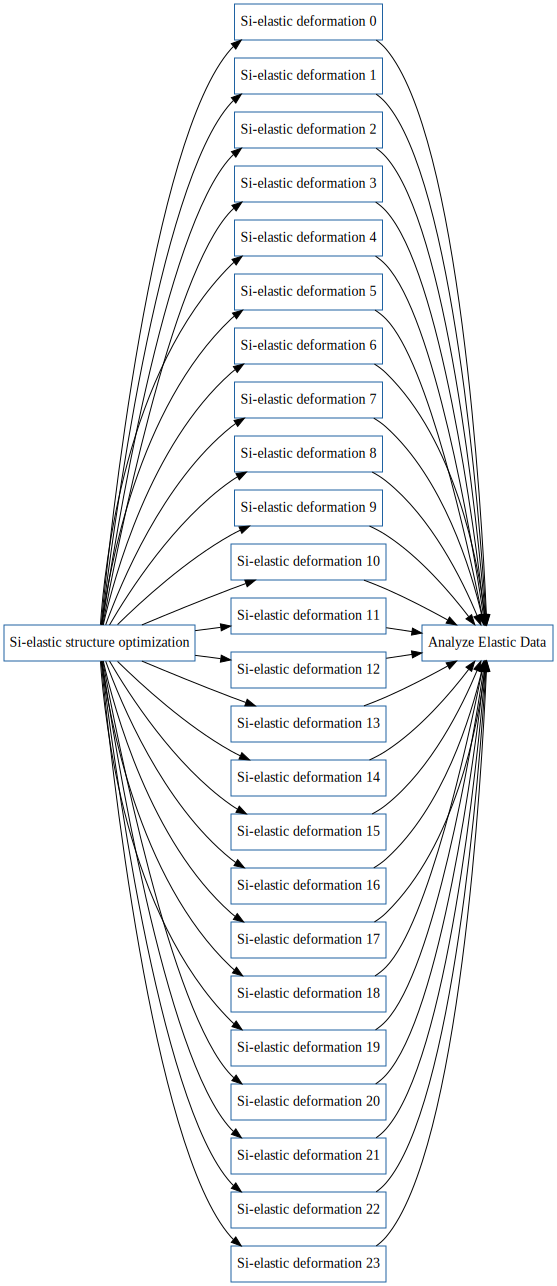

In [37]:
from mp_workshop.atomate import wf_to_graph
wf_to_graph(wf)

From our exploration of the workflow, we can see that the workflow has a "root" firework, which is the structure optimization firework, and a single "leaf" firework, which is the analysis task.  In between, we have several fireworks which have "elastic deformation" in their titles, each of which represents a calculation which will transform the output of the optimization firework by applying a unique strain.

In the analysis step, the stresses from those deformations and the strains are aggregated and used to fit an elastic tensor.  Let's examine the different types of fireworks using the graph tool.

Si-elastic structure optimization


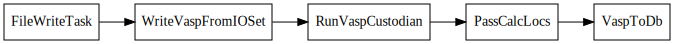

In [38]:
print(wf.fws[0].name)
wf_to_graph(wf.fws[0])

Si-elastic deformation 0


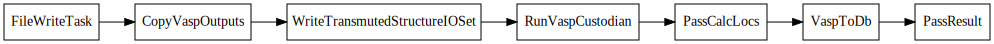

In [39]:
print(wf.fws[1].name)
wf_to_graph(wf.fws[1])

Analyze Elastic Data


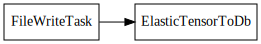

In [40]:
print(wf.fws[-1].name)
wf_to_graph(wf.fws[-1])

Note that the standard preset workflow for the elastic tensor uses many calculations in excess of what is required to determine the elastic tensor, which yields a higher-quality tensor in which some of the numerical noise is washed out over the duplicity of calculations.  Note that you can also generate a "minimal" elastic workflow which uses neither the more expensive DFT parameters nor the extended calculations.  Tensors generated using this workflow are typically not as accurate, but often work for simple semiconductors with a lot of symmetry.  Let's try it with bulk silicon.

In [58]:
wf = wf_elastic_constant_minimal(structure)

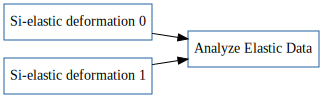

In [59]:
wf_to_graph(wf)

Note that for silicon, the two deformation tasks are a single normal deformation along the x axis (which are equivalent to those along the y- and z-axis), and a single shear deformation (equivalent to the two others normally included).  Since this is considerably simpler, we'll run this as our example.

To run the workflow, we import our launchpad and rocket launcher tools.  Since we can't use VASP in the workflow, we're also going to "fake" vasp by copying files rather than running the binary.

In [60]:
from fireworks import LaunchPad
from mp_workshop.atomate import use_fake_vasp_workshop

In [61]:
wf.name

'Si:elastic constants'

In [62]:
wf = use_fake_vasp_workshop(wf)
lpad.add_wf(wf)

2019-07-17 18:17:20,564 INFO Added a workflow. id_map: {-2432: 1, -2431: 2, -2430: 3}


{-2432: 1, -2431: 2, -2430: 3}

Now we can run the workflow either in the notebook using the pythonic fireworks rocket launcher or using `qlaunch` from the linux command line.

In [63]:
from fireworks.core.rocket_launcher import rapidfire

In [64]:
import os

In [65]:
if not os.path.exists('temp'):
    os.makedirs('temp')
    os.chdir("temp")
rapidfire(lpad)

2019-07-17 18:17:26,965 INFO Created new dir /home/jovyan/work/lessons/atomate/temp/temp/temp/launcher_2019-07-17-18-17-26-964974
2019-07-17 18:17:26,966 INFO Launching Rocket
2019-07-17 18:17:27,037 INFO RUNNING fw_id: 3 in directory: /home/jovyan/work/lessons/atomate/temp/temp/temp/launcher_2019-07-17-18-17-26-964974
2019-07-17 18:17:27,051 INFO Task started: FileWriteTask.
2019-07-17 18:17:27,052 INFO Task completed: FileWriteTask 
2019-07-17 18:17:27,066 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}}.
2019-07-17 18:17:27,082 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}} 
2019-07-17 18:17:27,087 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-17 18:17:27,108 INFO atomate.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2019-07-17 18:17:27,131 INFO atomate.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2019-07-17 18:17:27,133 INFO 

/opt/conda/lib/python3.7/site-packages/pymatgen/analysis/elasticity/elastic.py:911: UserWarning:

No eq state found, returning zero voigt stress



2019-07-17 18:17:29,098 INFO Task completed: {{atomate.vasp.firetasks.parse_outputs.ElasticTensorToDb}} 
2019-07-17 18:17:29,150 INFO Rocket finished


## Powerups

Atomate contains a number of tools for modifying workflows, known as "powerups" which are functions which will modify the workflows in commonly desired ways.  For example, if you want to modify the parameters of a VASP calculation, you can use the add_modify_incar powerup to change these for every firework in the workflow.

### add_modify_incar

In [66]:
from atomate.vasp.powerups import add_modify_incar

In [67]:
wf = get_wf(structure, "bandstructure.yaml")

In [84]:
wf_to_graph(wf.fws[0])

AttributeError: 'list' object has no attribute 'fws'

In [69]:
modified = add_modify_incar(wf, {"incar_update": {"ENCUT": 700}})

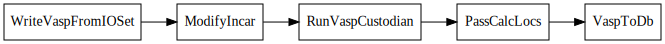

In [70]:
wf_to_graph(modified.fws[0])

Prior to the execution of the VASP calculation, a ModifyIncar firetask is inserted which will read the incar and modify the ENCUT parameter such that it matches our powerup specification.

### add_tags, add_structure_metadata

In [71]:
from atomate.vasp.powerups import add_tags

In [72]:
print("WF metadata: ", wf.metadata)
print("Last task: ", wf.fws[0].tasks[-1])

WF metadata:  {}
Last task:  <{{atomate.vasp.firetasks.parse_outputs.VaspToDb}}>:{'db_file': '>>db_file<<', 'additional_fields': {'task_label': 'structure optimization'}}


In [73]:
wf = add_tags(wf, ["photocathodes"])

In [74]:
print("WF metadata: ", wf.metadata)
print("Last task: ", wf.fws[0].tasks[-1])

WF metadata:  {'tags': ['photocathodes']}
Last task:  <{{atomate.vasp.firetasks.parse_outputs.VaspToDb}}>:{'db_file': '>>db_file<<', 'additional_fields': {'task_label': 'structure optimization', 'tags': ['photocathodes']}}


## A few other "complex" workflows.

Atomate contains a few workflows that will do more complicating things like calculations on surfaces.  Let's say I want to calculate the determine the hydrogen adsorption energy on every low-index facet of Pt.

In [76]:
from atomate.vasp.workflows.base.adsorption import get_wfs_all_slabs
from pymatgen import MPRester, Molecule

In [77]:
pt = mpr.get_structure_by_material_id("Pt", conventional_unit_cell=True)
adsorbate = Molecule("H", [[0, 0, 0]])

In [86]:
wf = get_wfs_all_slabs(pt, adsorbates = [adsorbate])

/opt/conda/lib/python3.7/site-packages/pymatgen/core/structure.py:638: UserWarning:

Not all sites have property bulk_wyckoff. Missing values are set to None.

/opt/conda/lib/python3.7/site-packages/pymatgen/core/structure.py:638: UserWarning:

Not all sites have property bulk_equivalent. Missing values are set to None.



'WF 0 ============================='

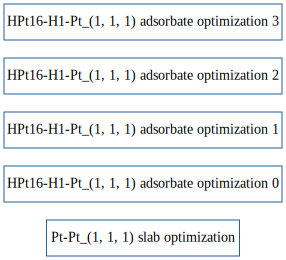

'WF 1 ============================='

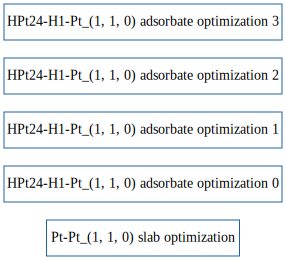

'WF 2 ============================='

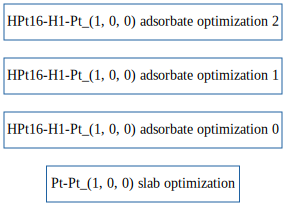

In [102]:
from IPython.display import display
display("WF 0 =============================")
display(wf_to_graph(wf[0]))
display("WF 1 =============================")
display(wf_to_graph(wf[1]))
display("WF 2 =============================")
display(wf_to_graph(wf[2]))

This is how you can do the requisite calculation to find the band-gap from an HSE calculation after the PBE bandstructure.

In [103]:
from atomate.vasp.workflows.presets.core import wf_bandstructure_plus_hse

In [104]:
wf = wf_bandstructure_plus_hse(structure)

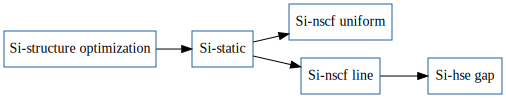

In [105]:
wf_to_graph(wf)

There's also support for workflows in FEFF and QChem.

In [106]:
from atomate.feff.workflows.core import get_wf_xas

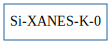

In [107]:
wf = get_wf_xas("Si", structure)
wf_to_graph(wf)

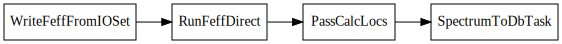

In [108]:
wf_to_graph(wf.fws[0])

In [109]:
#from atomate.qchem.workflows.base.double_FF_opt import get_wf_double_FF_opt
#from pymatgen import Molecule
#molecule = Molecule("CO", [[0, 0, 0], [0, 0, 1.23]])
#wf = get_wf_double_FF_opt(molecule, 0.5)
#wf_to_graph(wf)
#wf_to_graph(wf.fws[0])

## Analyzing workflow results

Our final example for atomate will take a set of tasks from our database and construct a phase diagram.

In [110]:
structures = mpr.get_structures("Al-Cr")
structures += mpr.get_structures("Al")
structures += mpr.get_structures("Cr")
for structure in structures:
    wf = get_wf(structure, "bandstructure.yaml")
    lpad.add_wf(wf)

2019-07-17 18:27:17,469 INFO Added a workflow. id_map: {-2474: 4, -2473: 5, -2472: 6, -2471: 7}
2019-07-17 18:27:17,486 INFO Added a workflow. id_map: {-2478: 8, -2477: 9, -2476: 10, -2475: 11}
2019-07-17 18:27:17,533 INFO Added a workflow. id_map: {-2482: 12, -2481: 13, -2480: 14, -2479: 15}
2019-07-17 18:27:17,549 INFO Added a workflow. id_map: {-2486: 16, -2485: 17, -2484: 18, -2483: 19}
2019-07-17 18:27:17,572 INFO Added a workflow. id_map: {-2490: 20, -2489: 21, -2488: 22, -2487: 23}
2019-07-17 18:27:17,584 INFO Added a workflow. id_map: {-2494: 24, -2493: 25, -2492: 26, -2491: 27}
2019-07-17 18:27:17,595 INFO Added a workflow. id_map: {-2498: 28, -2497: 29, -2496: 30, -2495: 31}
2019-07-17 18:27:17,605 INFO Added a workflow. id_map: {-2502: 32, -2501: 33, -2500: 34, -2499: 35}
2019-07-17 18:27:17,615 INFO Added a workflow. id_map: {-2506: 36, -2505: 37, -2504: 38, -2503: 39}
2019-07-17 18:27:17,625 INFO Added a workflow. id_map: {-2510: 40, -2509: 41, -2508: 42, -2507: 43}
2019-0

In [111]:
from maggma.stores import MongoStore

In [ ]:
lpad.

In [122]:
tasks = MongoStore(database="mp_workshop", collection_name="tasks")

In [123]:
tasks.connect()

In [124]:
doc = tasks.query_one()

In [125]:
doc.keys()

AttributeError: 'NoneType' object has no attribute 'keys'

In [47]:
doc['chemsys']

'Al'

In [48]:
doc = tasks.query_one(criteria={"chemsys": "Al"}, properties=['output'])

In [49]:
docs = tasks.query(criteria={"chemsys": "Al-Cr", 
                             "task_label": "structure optimization"},
                   properties=['output', 'formula_pretty'])
docs

In [50]:
docs = list(docs)

In [51]:
[d['formula_pretty'] for d in docs]

['AlCr2', 'Al8Cr5', 'Al45Cr7', 'Al3Cr']

In [52]:
fe_cr_tasks = []
for chemsys in ['Al', 'Cr', 'Al-Cr']:
    task_list = tasks.query(criteria={"chemsys": chemsys,
                                      "task_label": "structure optimization"},
                            properties=["output", "composition_unit_cell"])
    fe_cr_tasks.extend(list(task_list))

In [53]:
len(fe_cr_tasks)

16

In [54]:
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen import Composition

In [55]:
entries = []
for task in fe_cr_tasks:
    energy = task['output']['energy']
    composition = Composition.from_dict(task['composition_unit_cell'])
    entry = ComputedEntry(composition, energy)
    entries.append(entry)

In [56]:
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

In [57]:
pd = PhaseDiagram(entries)

In [58]:
plotter = PDPlotter(pd)

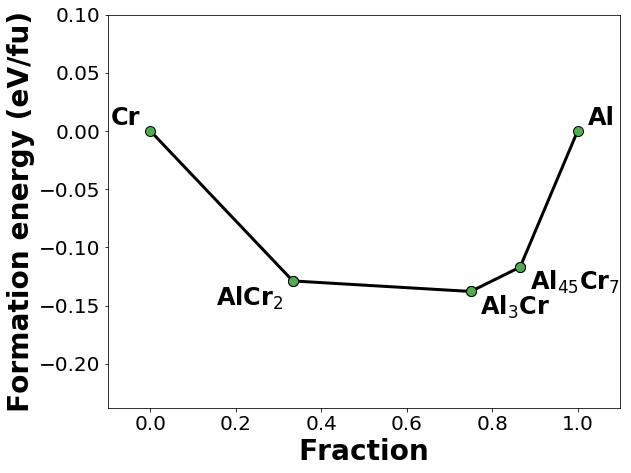

In [59]:
plotter.show()

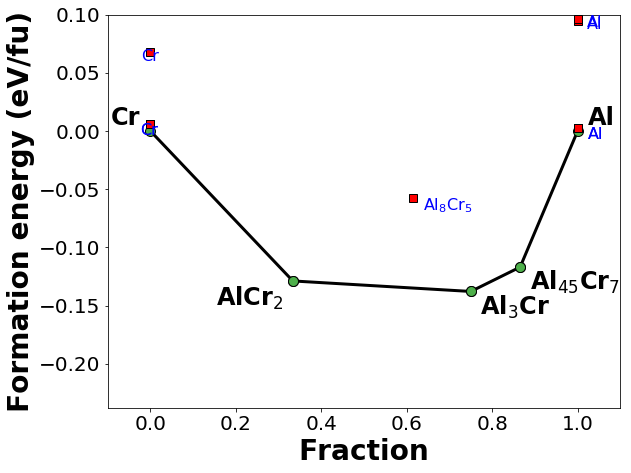

In [60]:
plotter.show_unstable = True
plotter.show()